In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
from typing import Union
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

# Grab data from data folder

In [2]:
def np_piece_data_from_csv(num, piece):
    filename = f'/Users/HAQbook/Desktop/graaaaphs/data/piano01_00{str(piece)}_p{str(num)}.csv' #performance number 1-6
    repo = pd.read_csv(filename,header=0)
    columns=['Frame', 'Time (Seconds)']
    repo = repo.drop(columns, axis=1)
    vals = repo.to_numpy(dtype=float)
    return repo, vals

# Useful shorthand

In [3]:
'''Column names of limbs that we care about atm:
- STRN
- LASI
- LSHO 
- LELB 
- LFIN
- LWRA
- LWRB'''

'''-------------CHOICES--------------'''
angLSHO = ["LASI","LSHO","LELB"]
angLELB = ["LSHO","LELB","LWRA"]
angLWRA = ["LELB","LWRA","LFIN"]
angRSHO = ["RASI","RSHO","RELB"]
angRELB = ["RSHO","RELB","RWRA"]
angRWRA = ["RELB","RWRA","RFIN"]

coarseness = 20 #min: 5 

#Frequency plotting things
angLST = [angLSHO,angLELB,angLWRA,angRSHO,angRELB,angRWRA] # list of angles to loop through
limbLST = ['LSHO','LELB','LWRA','RSHO','RELB','RWRA'] # list of angles to loop through

# Do stuff

In [4]:
#repeatedly needed

def getDegrees2D(repo, vals, POINTSx):
    '''Gets angle between three points ps=[p1,p2,p3] over all frames'''
    p1x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[0]+"x") # get the x,y,z data for each of the three points over all frames
    p2x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[1]+"x")
    p3x = repo.columns.get_loc("piano_pilot_01:"+POINTSx[2]+"x")

    unit_vector = lambda x: normalize(x, axis = 1, norm = 'l2') # helper function to normalise vectors, anonymous function woah

    v1 = vals[:,p1x:p1x+3] - vals[:,p2x:p2x+3] # 3 points -> 2 vectors
    v2 = vals[:,p3x:p3x+3] - vals[:,p2x:p2x+3]
    v1_u = unit_vector(v1) # vectors -> unit vectors
    v2_u = unit_vector(v2)
    ang = np.rad2deg(np.arccos(np.sum(v1_u*v2_u, axis=1))) # calculate angle between vectors
    return(ang) 

In [5]:
def plot_degVStime2Ds(*data, **args):
    '''SINGLE DATASOURCE!! 
    For each triplet ps=[p1,p2,p3] in list, 
    plots angle between those three points ps_n over all n frames.'''
    repo,vals = data[0],data[1] #<'DataFrame'>,<'numpy.ndarray'>
    lisPOINTSx = args['lisPOINTSx']
    ln = vals.shape[0] # can change this if you don't want over the entire piece

    X = np.linspace(0, ln//240, ln) # x-axis for graph: frame # -> seconds 
    for count,POINTSx in enumerate(lisPOINTSx):
        ang = getDegrees2D(repo, vals, POINTSx)
        plt.plot(X,ang,alpha=0.5, label=count) # generate plot
    plt.ylabel("Degrees")
    plt.xlabel("Time (sec)")
    plt.legend()
    plt.show()

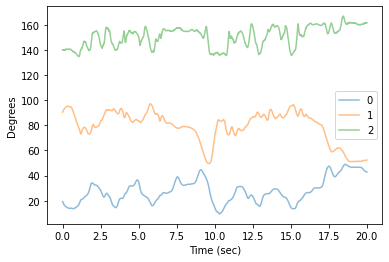

In [6]:
def main():
    piece = 3
    perf = 3
    repo,vals = np_piece_data_from_csv(perf,piece)
    angleBetweens = [["LASI","LSHO","LELB"],["LSHO","LELB","LWRA"],["LELB","LWRA","LFIN"]]
    
    plot_degVStime2Ds(repo, vals, lisPOINTSx = angleBetweens)

if __name__ == '__main__':
    main()

In [7]:
def standardize_len_attempt_1(lists: list[np.array]):
    x = lists[0]
    standardized_len_lists = []
    for lst in lists:
        #Stretch/compress y to be the length of first list
        xp = np.linspace(x[0], x[-1], len(lst))
        new_lst = np.interp(x, xp, lst) # interpolate the lst values at the new x values
        standardized_len_lists.append(new_lst) 
    return(standardized_len_lists)

def standardize_len(lists: list[np.array]):
    '''standardize the length of the arrays by interpolation 
    (sort of stretching them performances to all be the same length for ease of comparison)'''
    x = np.linspace(0, len(lists[0]) - 1, len(lists[0]))
    standardized_len_lists = []
    for lst in lists:
        #Stretch/compress y to be the length of first list
        xp = np.linspace(x[0], x[-1], len(lst))
        new_lst = np.interp(x, xp, lst) 
        standardized_len_lists.append(new_lst) 
    return(standardized_len_lists)

In [8]:
def removeOutliers(y):
    # Calculate the IQR fences
    #print(f'{np.min(y)=} and {np.max(y)=}')
    x = np.linspace(np.min(y), np.max(y), num=len(y)) #set of x values that cover the range of the data and are sufficiently dense to capture any rapid changes in the y values. 
    Q1 = np.percentile(y, 25)
    Q3 = np.percentile(y, 75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR

    # Smooth the outliers with linear interpolation
    outliers = (y < lower_fence) | (y > upper_fence)
    x_outliers = x[outliers]
    f = interp1d(x[~outliers], y[~outliers], kind='linear', bounds_error=False, fill_value='extrapolate')
    y_smoothed = f(x_outliers)

    # Replace the outliers with the smoothed values
    y[outliers] = y_smoothed
    return(y)

def envelope_attempt_1(array): # too fine
    analytic_signal = hilbert(array) # Compute the analytic signal
    envelope = np.abs(analytic_signal) # Compute the envelope of the signal
    return(envelope)

In [41]:
def envelopeUpper(array, PROMINENCE, WIDTH):
    ln = len(array)
    X = np.linspace(0, ln//240, ln) 
    # Find the peaks in the signal
    peaks, _ = find_peaks(array, prominence=PROMINENCE, width=WIDTH)
    return(X[peaks], array[peaks])
def envelopeLower(array, PROMINENCE, WIDTH):
    ln = len(array)
    X = np.linspace(0, ln//240, ln) 
    # Find the peaks and prominences of the signal
    peaks, properties = find_peaks(array, prominence=PROMINENCE, width=WIDTH)
    prominences = properties['prominences']

    # Find the valleys of the signal
    valleys = []
    for i in range(len(peaks)-1):
        valley = np.argmin(array[peaks[i]:peaks[i+1]]) + peaks[i]
        valleys.append(valley)
    valleys = np.array(valleys)
    return(X[valleys], array[valleys])


In [93]:
def plot_func(piece: Union[int, list[int]], perf: Union[int, list[int]], limb: list[str], env: bool = False, prominence: int = 100, width: int = 3, color = 'regular') -> None:
    lisANGLES, lisLABELS = [], []

    cond = isinstance(piece, list)

    if cond:
        objects = piece
        lisLABELS_str = '_piece'
        title_func = lambda x, y, z: f'Standardized length {x} for performance {y} over pieces {z}, outliers removed'
    else:
        objects = perf
        lisLABELS_str = '_perf'
        title_func = lambda x, y, z: f'Standardized length {x} for piece {y} over performances {z}, outliers removed'

    for obj in objects:
        if cond: repo, vals = np_piece_data_from_csv(perf, obj)
        else: repo, vals = np_piece_data_from_csv(obj, piece)
        ang = getDegrees2D(repo, vals, POINTSx = limb)
        lisANGLES.append(ang)
        lisLABELS.append(f'{limb[1]}{lisLABELS_str}{obj}')

    if cond:
        plot_degVStime2Dm(lisANGLES, lisLABELS, title = title_func(limb[1], perf, objects), ENV=env, PROMINENCE=prominence, WIDTH=width, COLOR=color)
    else:
        plot_degVStime2Dm(lisANGLES, lisLABELS, title = title_func(limb[1], piece, objects), ENV=env, PROMINENCE=prominence, WIDTH=width, COLOR=color)


def plot_degVStime2Dm(*data, **args):
    '''MULTI DATASOURCE!! For each array in lisANGLES, 
    plot them over length of the longest array over time.
    Label each line by the corresponding label from lisLABELS.'''
    env = args.get('ENV')
    prominence = args.get('PROMINENCE')
    width = args.get('WIDTH')
    lisANGLES, lisLABELS = data[0], data[1]
    lisANGLES = standardize_len(lisANGLES)
    title = args.get('title', '') #.get: If the key is not found, the default value of an empty string is used

    #plt.figure(figsize=(18, 5))
    for count,ang in enumerate(lisANGLES):
        colr = args.get('COLOR')
        if args.get('COLOR') == 'regular':
            colr = ((6-count)/6,0.4,(count+1)/6,0.8)
        ang = removeOutliers(ang)
        ln = np.size(lisANGLES[count],0)
        X = np.linspace(0, ln//240, ln) # x-axis for graph: frame # -> seconds 
        if env:
            plt.plot(X,ang,color=colr,alpha=.3) # generate plot
            plt.plot(envelopeUpper(ang, prominence, width)[0],envelopeUpper(ang, prominence, width)[1],color=colr, label=lisLABELS[count])
            plt.plot(envelopeLower(ang, prominence, width)[0],envelopeLower(ang, prominence, width)[1],color=colr)
        else: plt.plot(X,ang,color=colr, label=lisLABELS[count]) # generate plot
    plt.ylabel("Degrees")
    plt.xlabel("Time (sec)")
    if env:
        plt.title('Envelope of '+title)
    else:
        plt.title(title)
    plt.legend()
    #plt.show() #comment out when data is needed, not plot


## Envelope

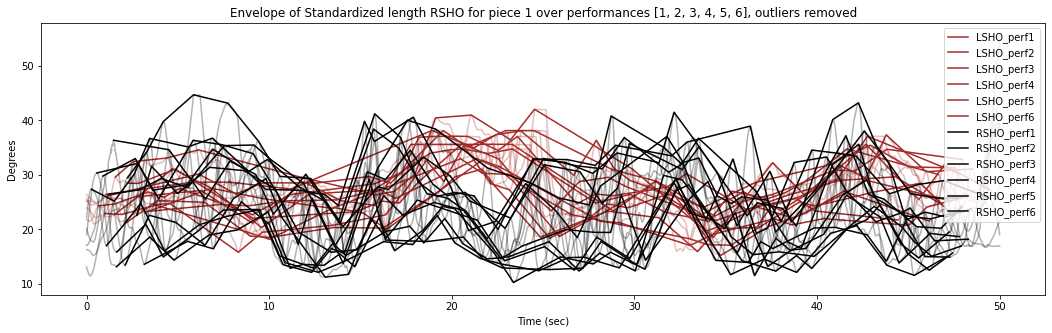

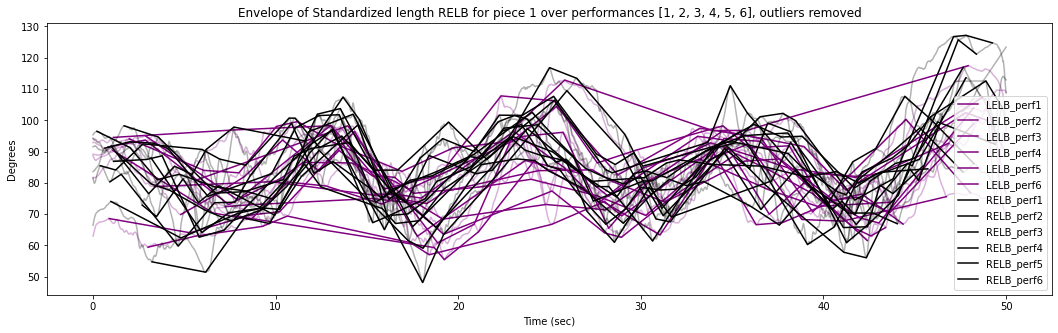

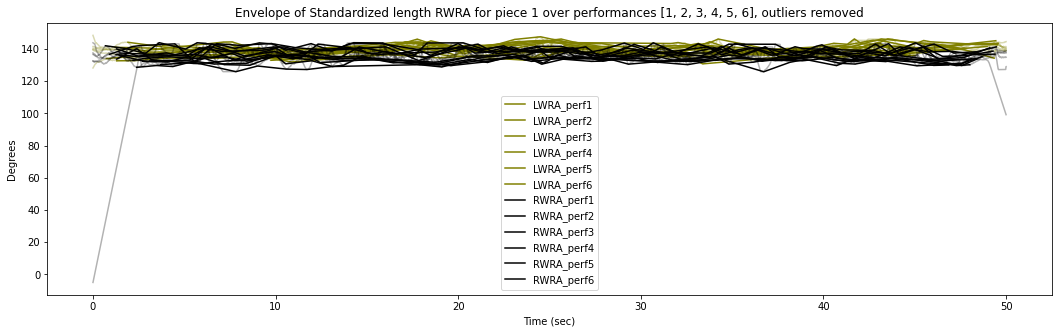

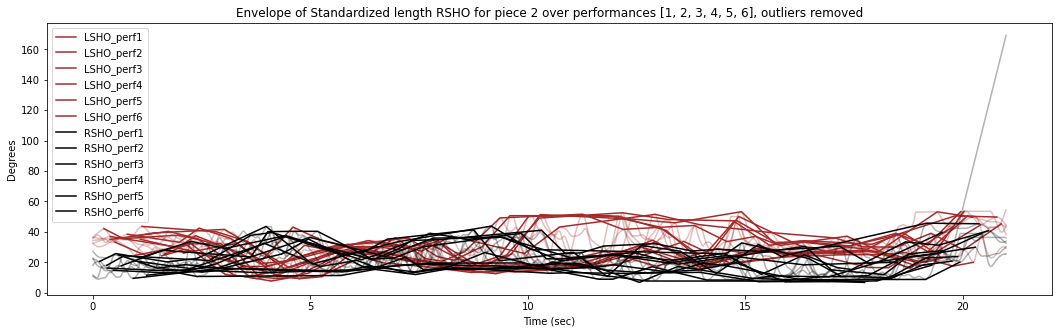

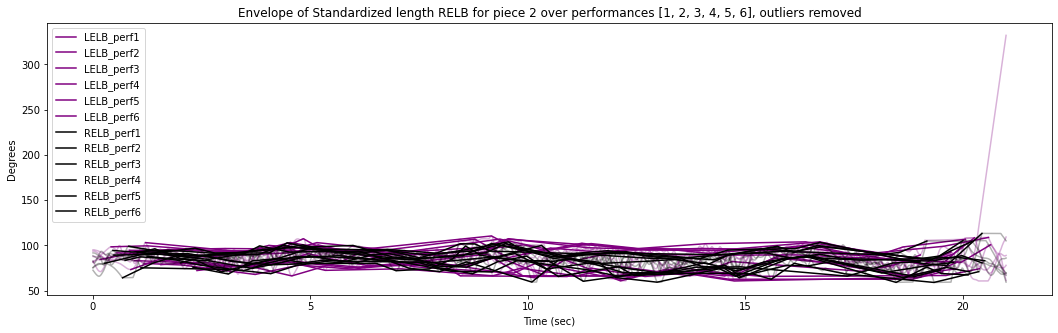

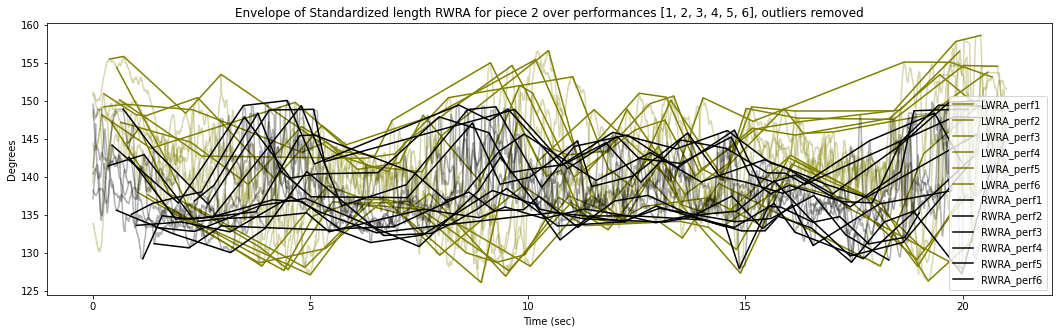

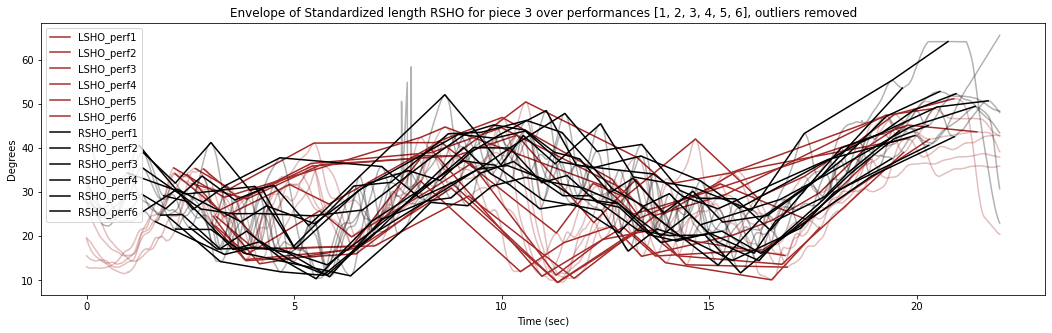

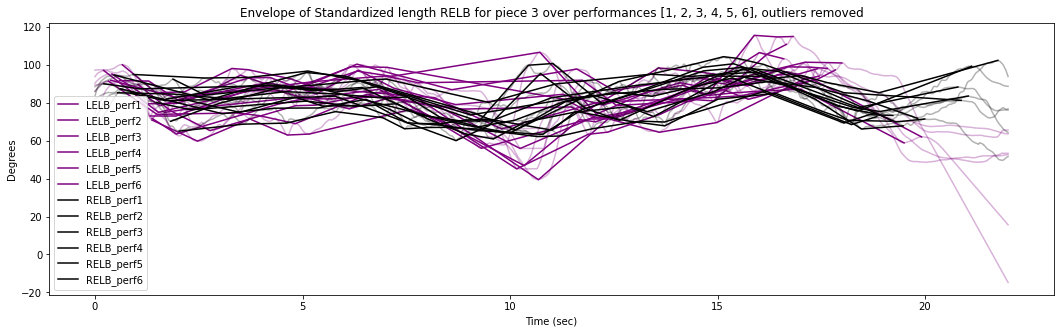

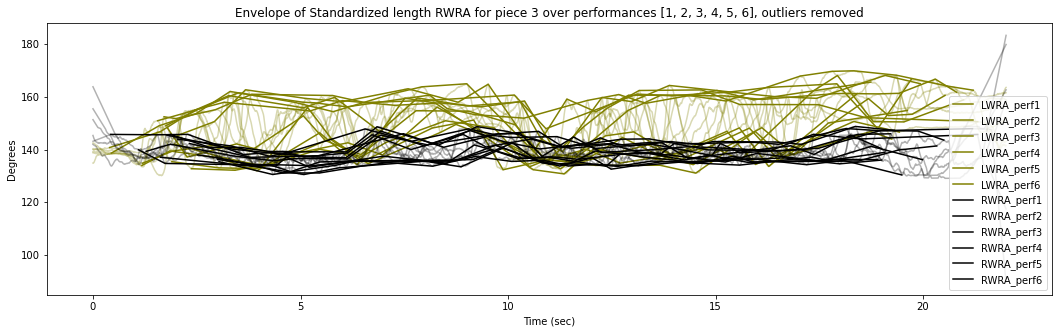

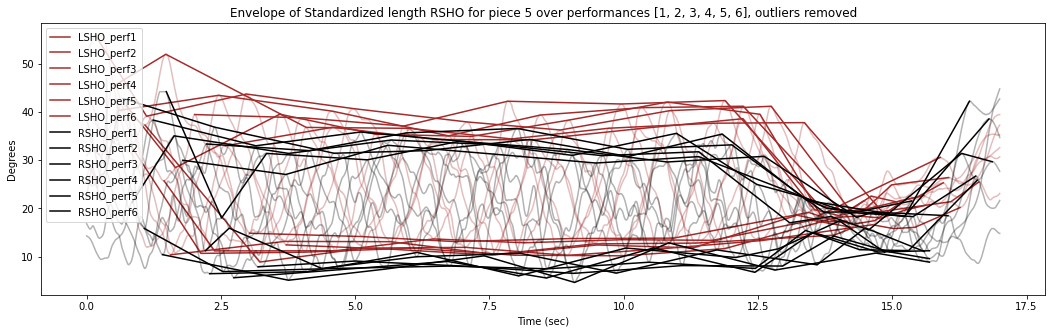

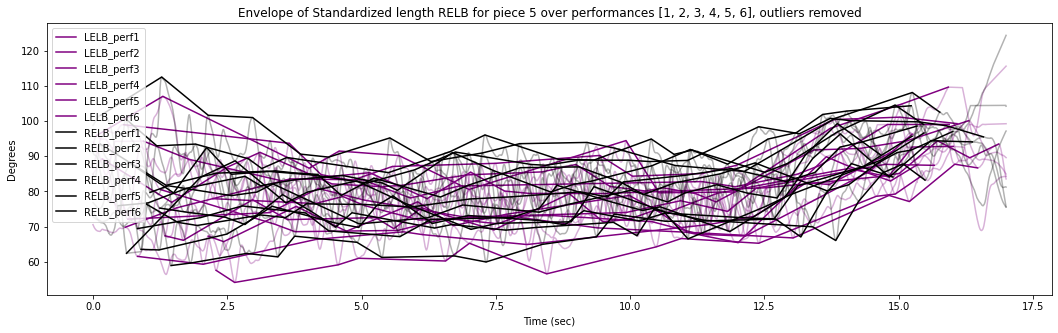

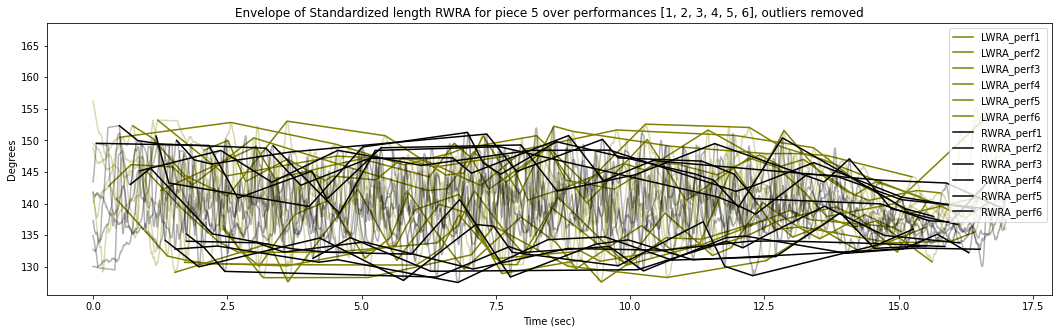

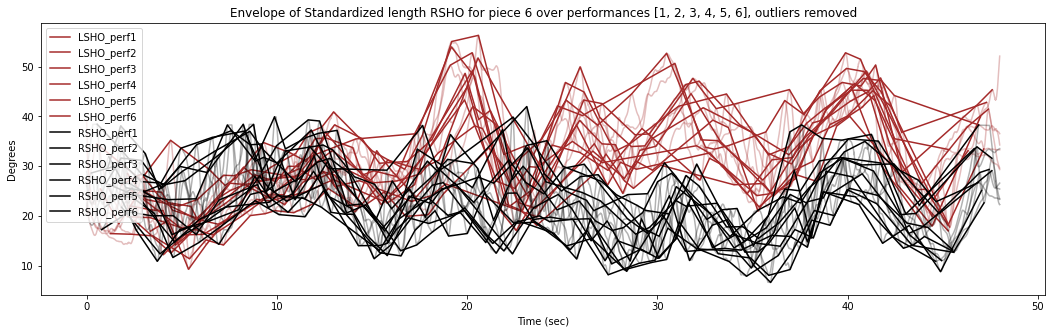

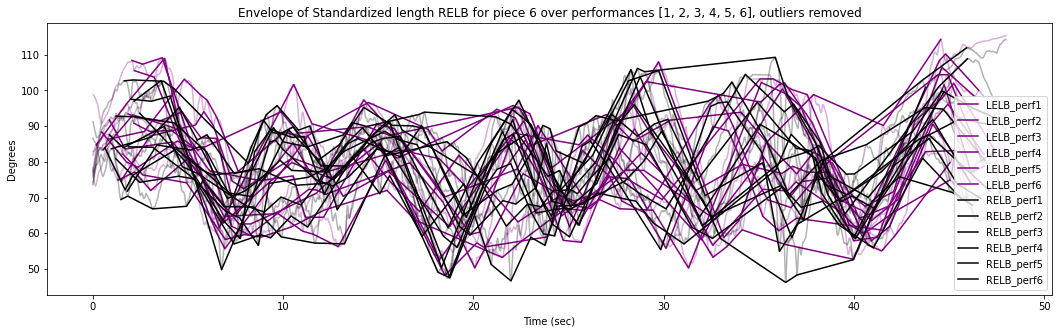

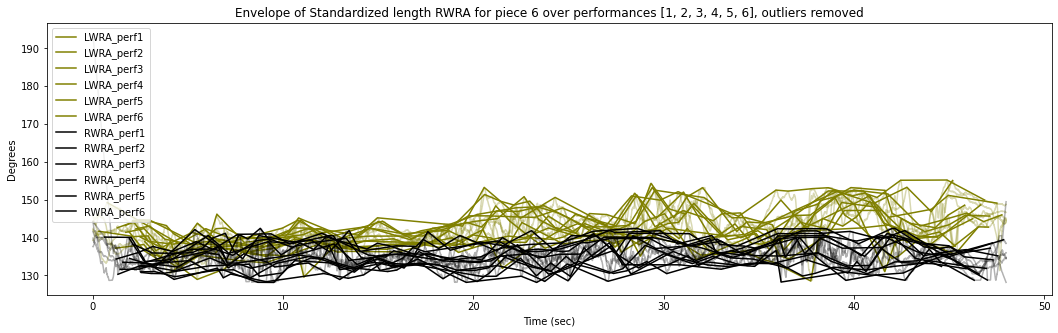

In [101]:
# run multi for perfs
def main():
    for piece in [1,2,3,5,6]:
        plt.figure(figsize=(18, 5))
        perfs = [1,2,3,4,5,6]
        plot_func(piece, perfs, angLSHO, env=True, prominence = 1, width = 40, color = 'brown') 
        plot_func(piece, perfs, angRSHO, env=True, prominence = 1, width = 40, color = 'black') 
        plt.savefig(f'/Users/HAQbook/Desktop/graaaaphs/2D_envelope_LR_SHO_all_perfs_piece{piece}.png')
        plt.show()

        plt.figure(figsize=(18, 5))
        perfs = [1,2,3,4,5,6]
        plot_func(piece, perfs, angLELB, env=True, prominence = 1, width = 40, color = 'purple') 
        plot_func(piece, perfs, angRELB, env=True, prominence = 1, width = 40, color = 'black') 
        plt.savefig(f'/Users/HAQbook/Desktop/graaaaphs/2D_envelope_LR_ELB_all_perfs_piece{piece}.png')
        plt.show()

        plt.figure(figsize=(18, 5))
        perfs = [1,2,3,4,5,6]
        plot_func(piece, perfs, angLWRA, env=True, prominence = 1, width = 40, color = 'olive') 
        plot_func(piece, perfs, angRWRA, env=True, prominence = 1, width = 40, color = 'black') 
        plt.savefig(f'/Users/HAQbook/Desktop/graaaaphs/2D_envelope_LR_WRA_all_perfs_piece{piece}.png')
        plt.show()
if __name__ == '__main__':
    main()

In [12]:
def plot_degVSdeg2D(*data, **args):
    '''For each triplet ps=[p1,p2,p3] in list, plots angle between three points ps_n over all frames.'''
    repo,vals = np_piece_data_from_csv(data[0],data[1])
    lisPOINTSx = data[3] # the angle that all other angles will be compared to 
    xPOINTSx = lisPOINTSx[data[2]]
    title = args.get('title', '')
    X = getDegrees2D(repo, vals, xPOINTSx) # x-axis for graph
    for count,POINTSx in enumerate(lisPOINTSx):
        Y = getDegrees2D(repo, vals, POINTSx)
        plt.plot(X,Y,alpha=0.5, label=f'limb {count} vs {data[2]}') # generate plot
    plt.ylabel("Degrees")
    plt.xlabel("Degrees")
    plt.legend()
    plt.title(title)
    plt.show()

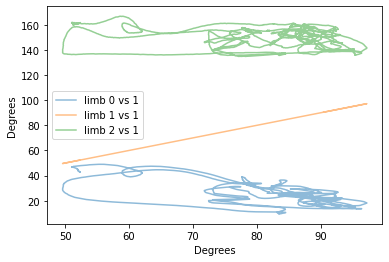

In [13]:
# run deg vs deg 2d
def main():
    piece = 3
    perf = 3
    limbLST = [["LASI","LSHO","LELB"],["LSHO","LELB","LWRA"],["LELB","LWRA","LFIN"]]
    limb = 1 # index of limbLST
    plot_degVSdeg2D(piece, perf, limb, limbLST, title = '')

if __name__ == '__main__':
    main()


# Weird ass thing, working for no reason. Ignore

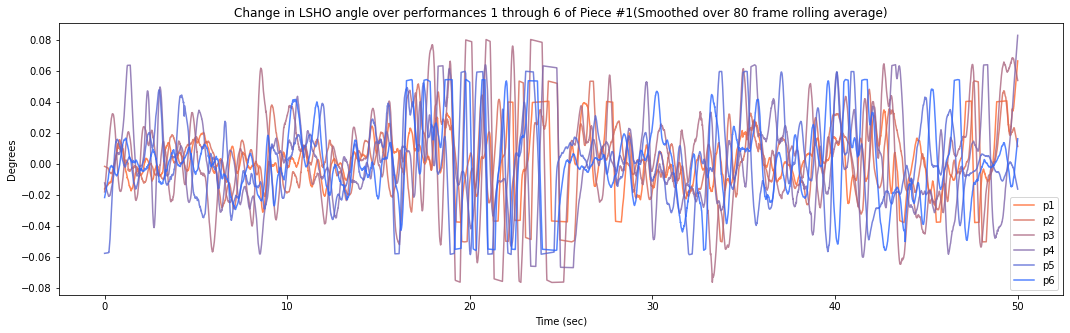

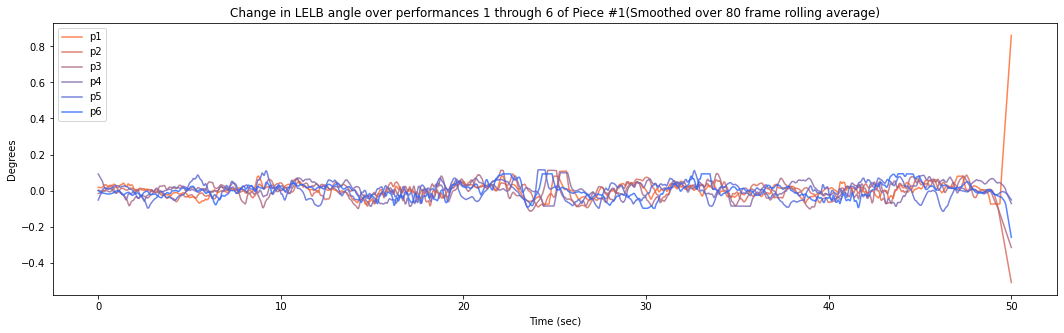

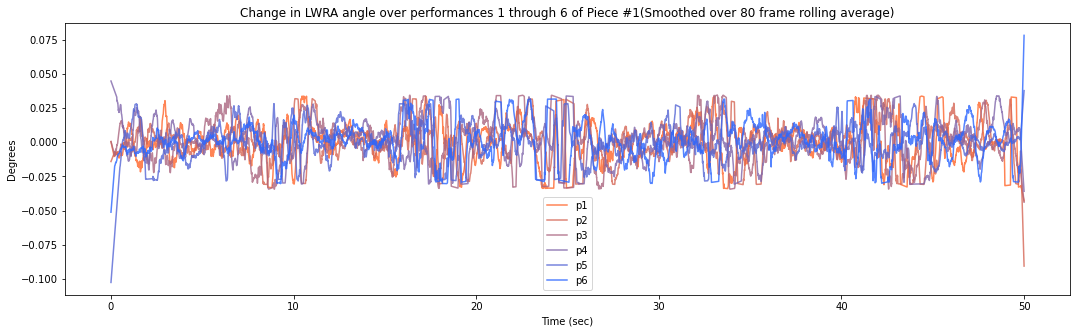

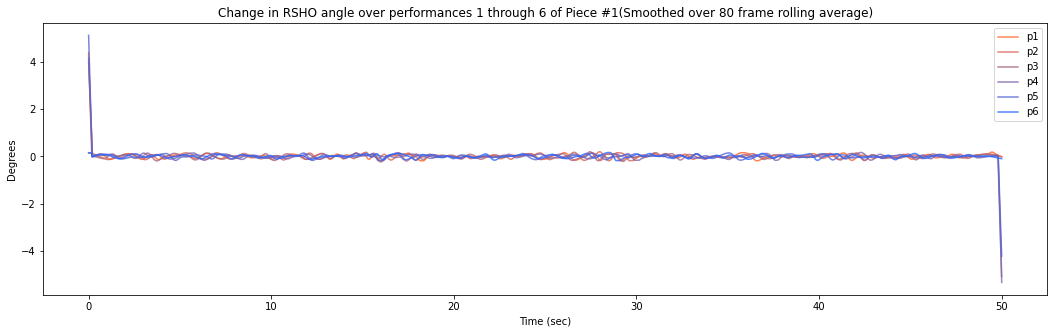

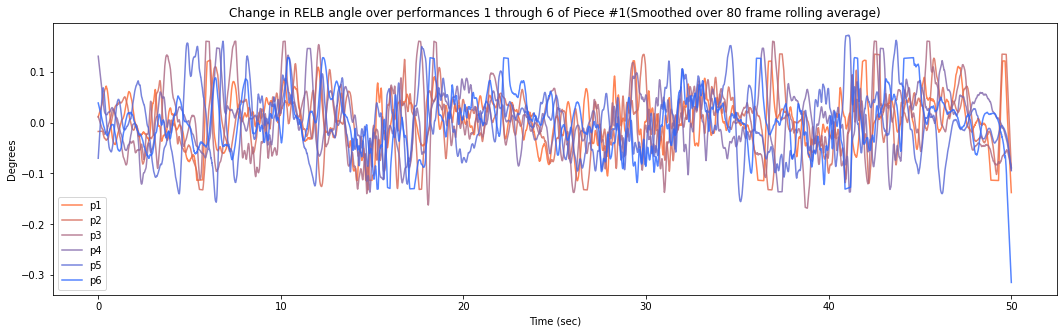

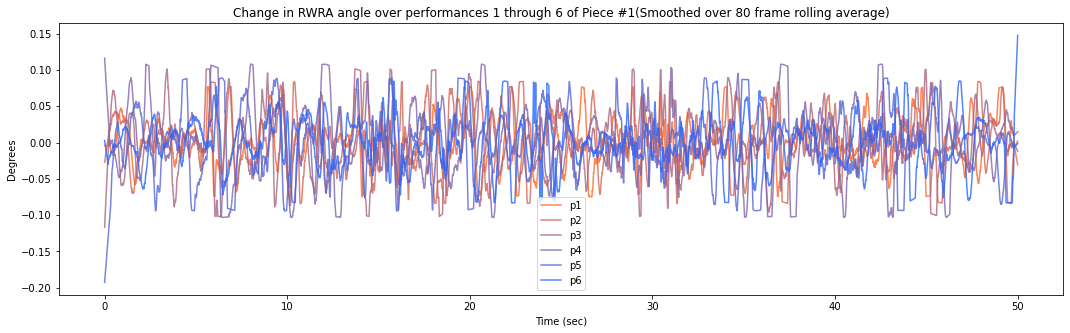

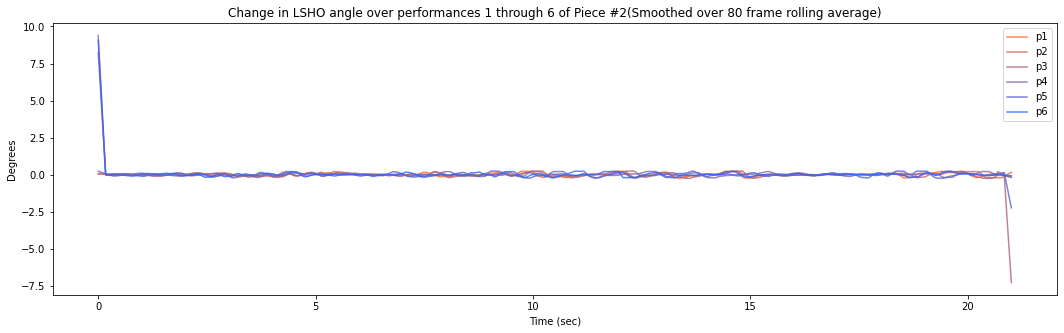

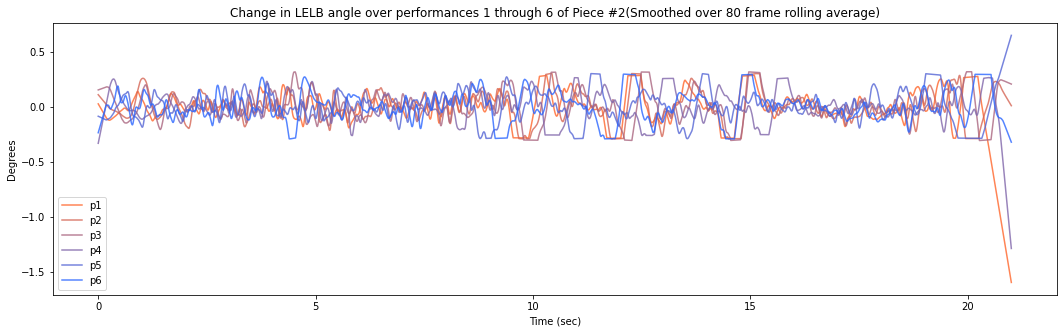

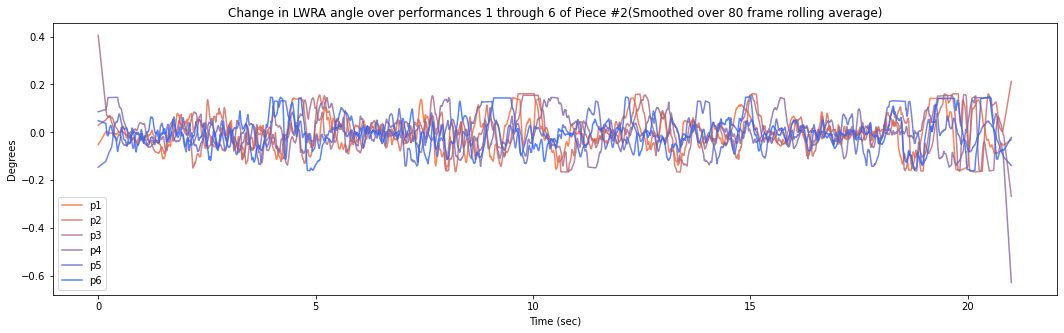

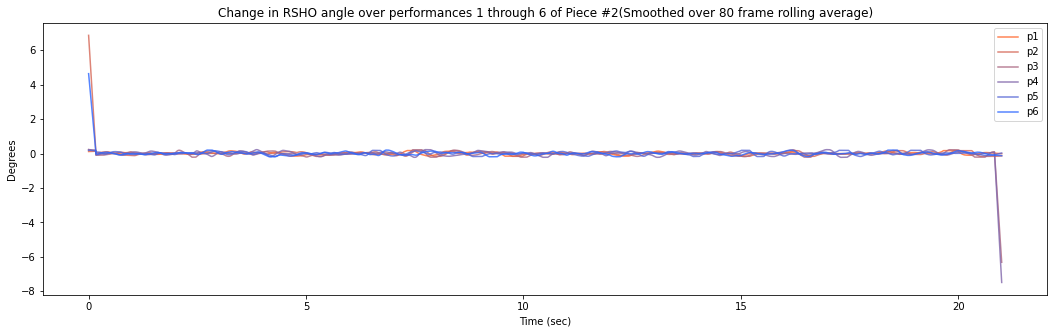

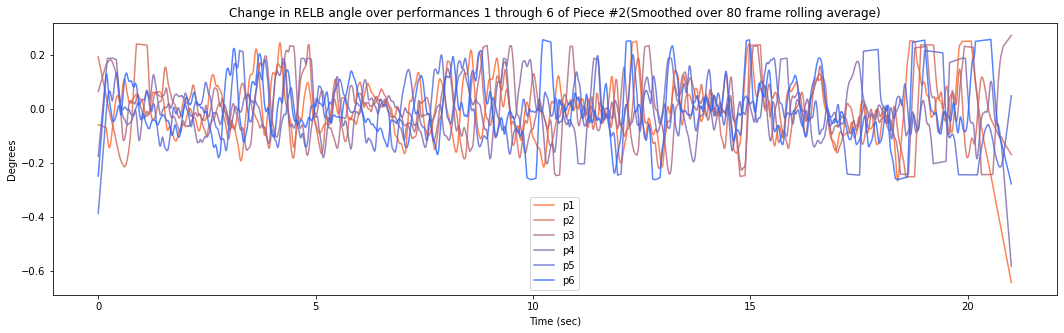

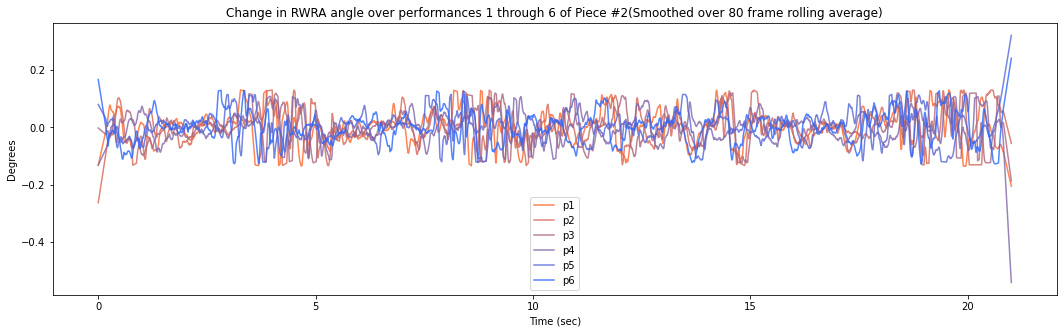

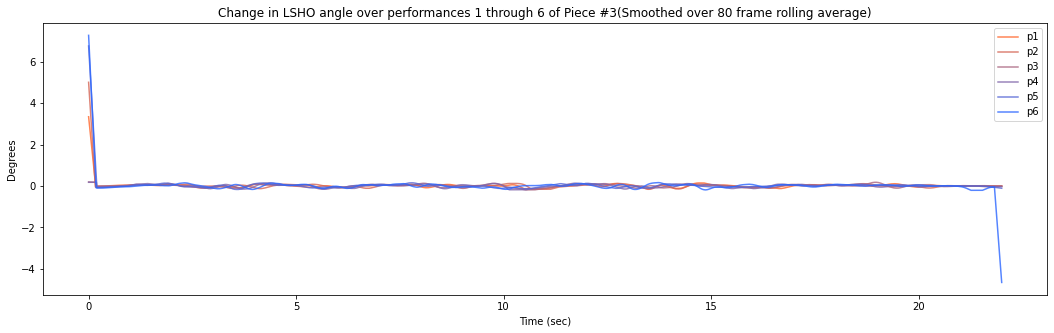

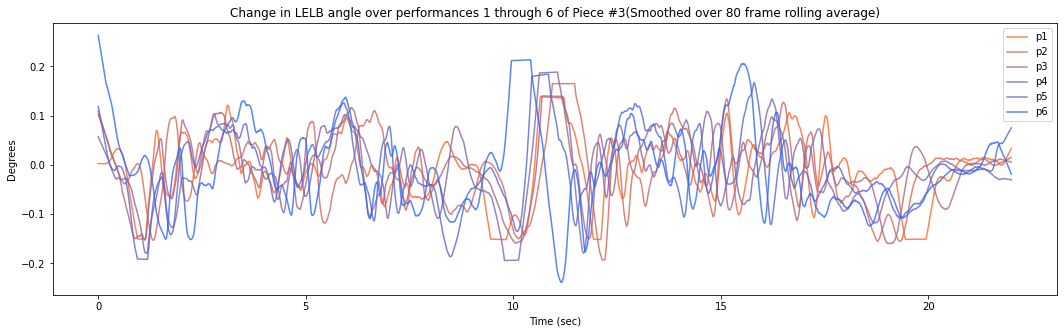

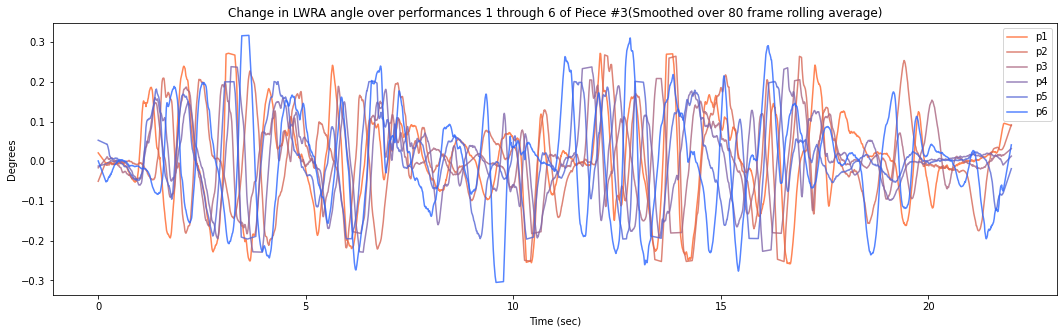

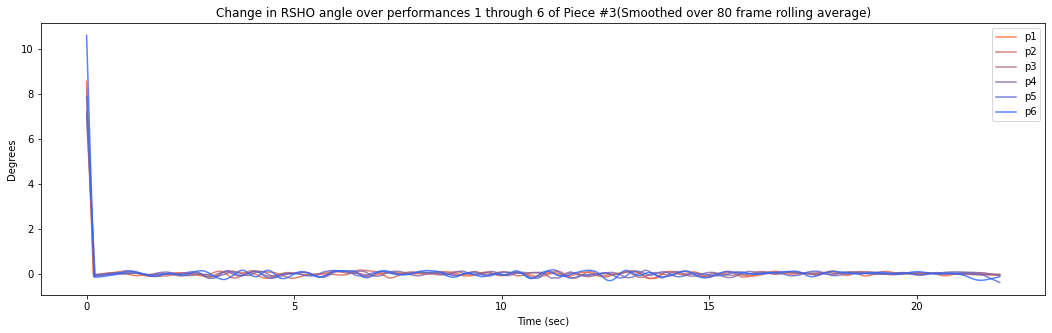

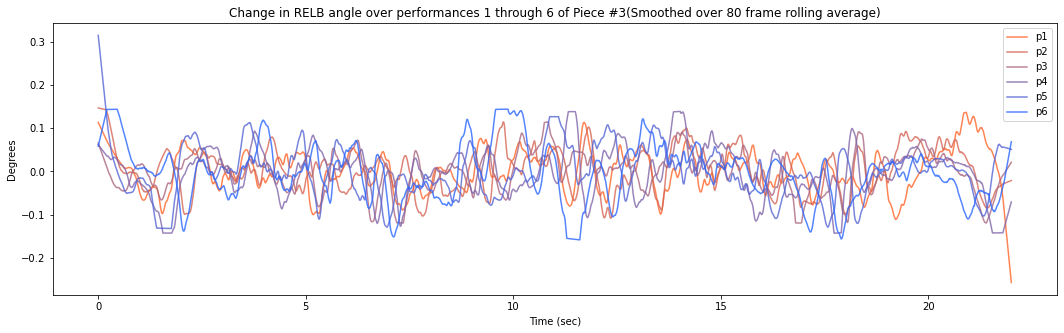

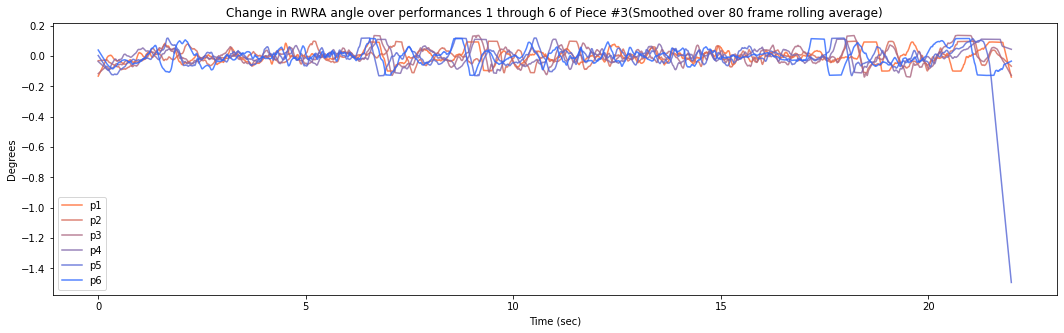

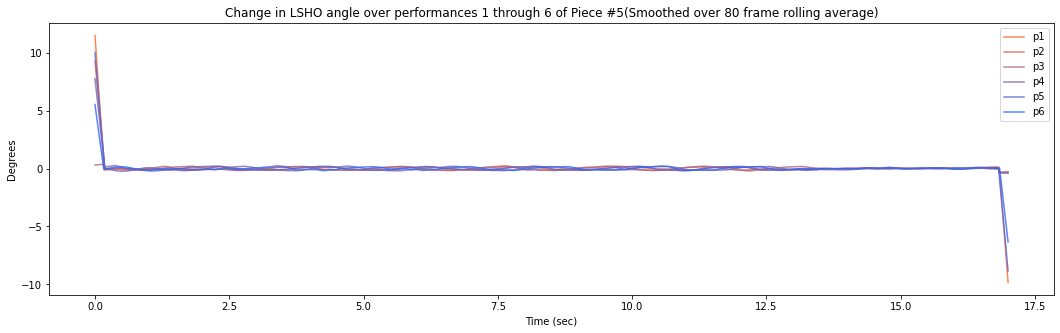

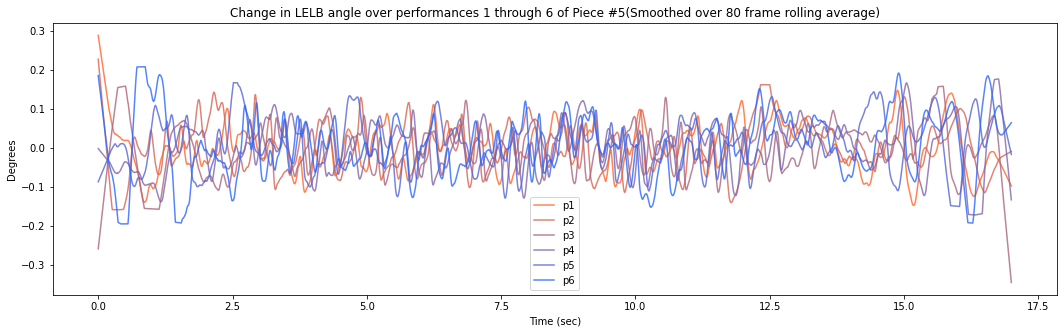

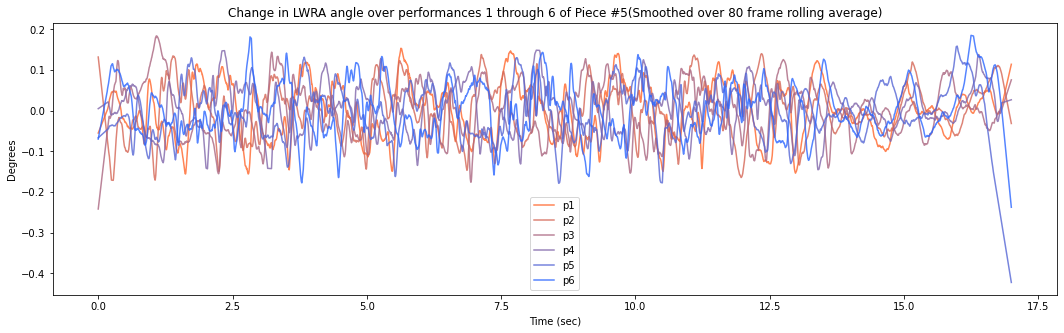

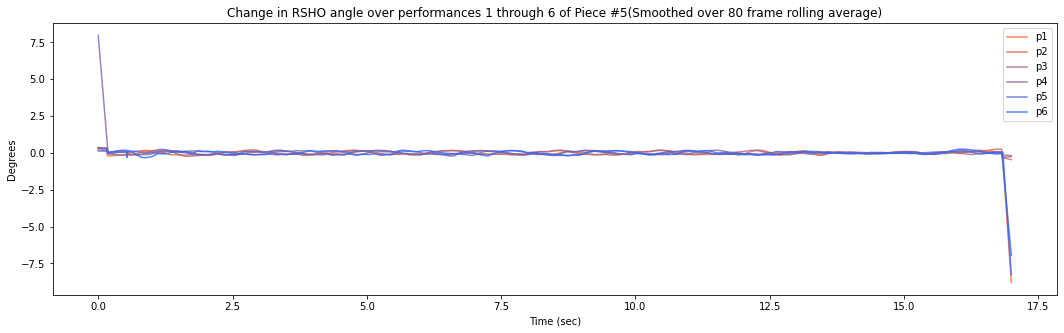

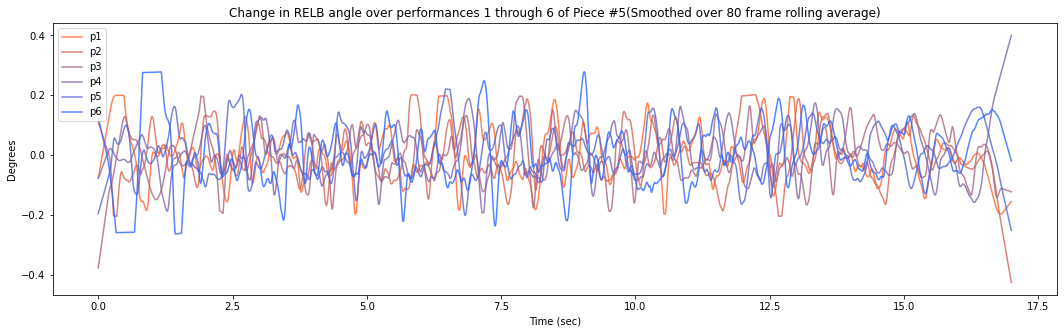

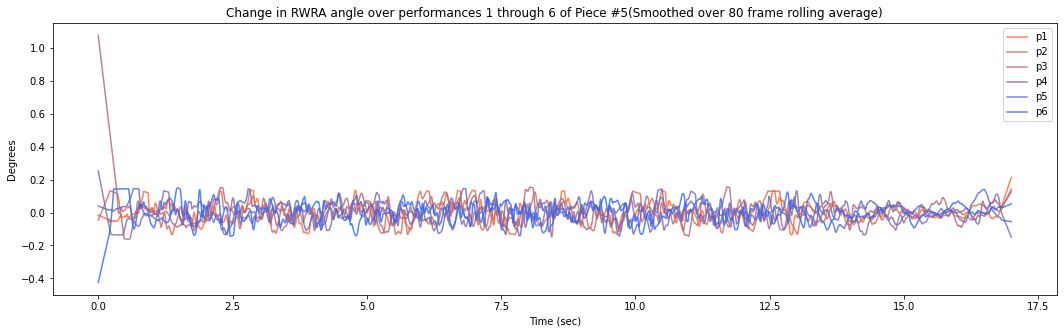

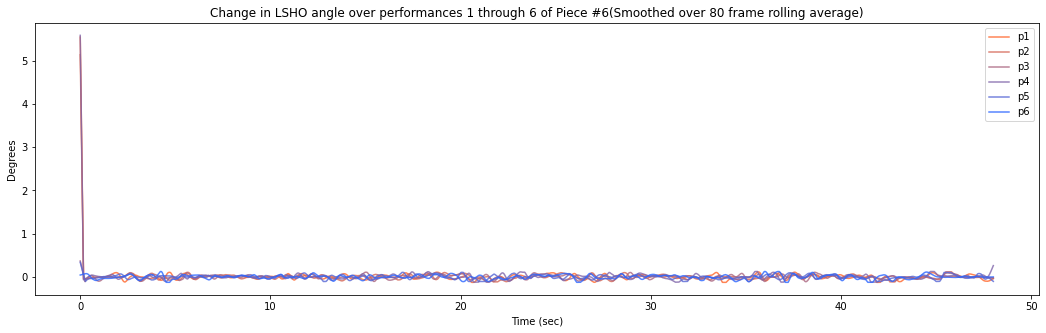

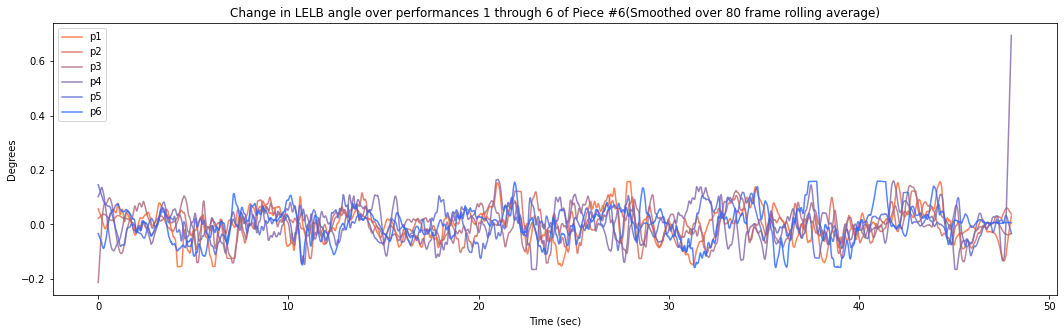

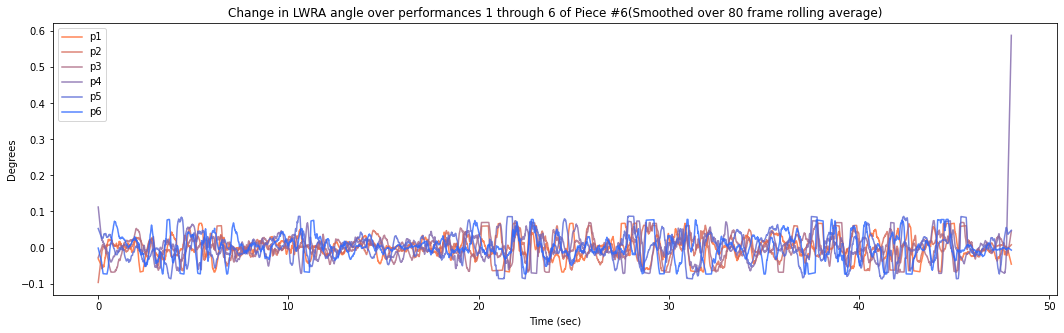

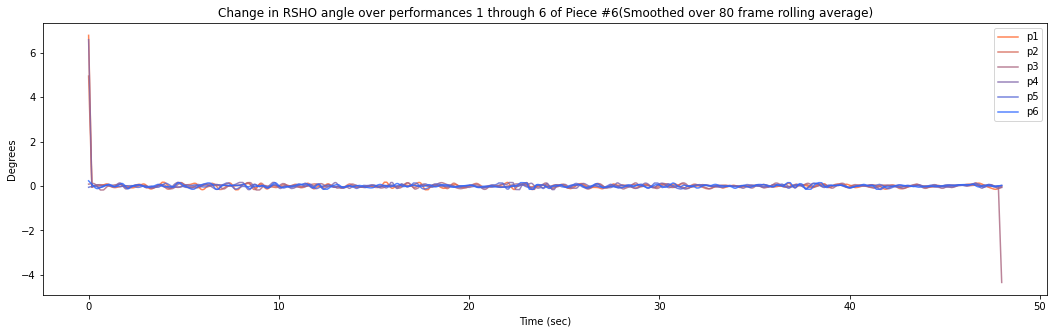

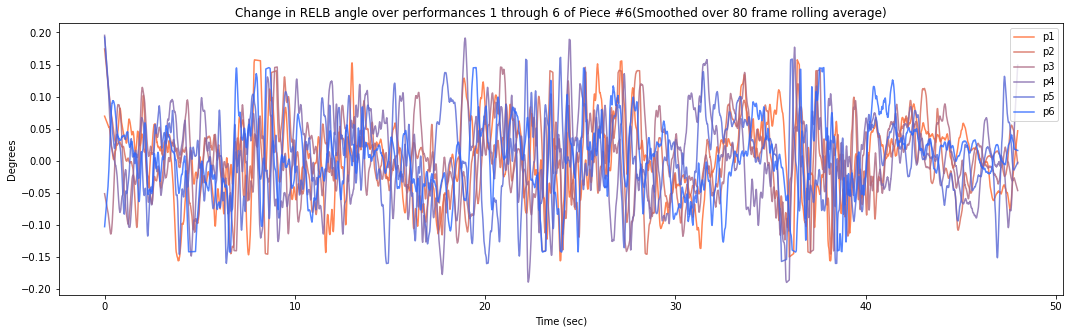

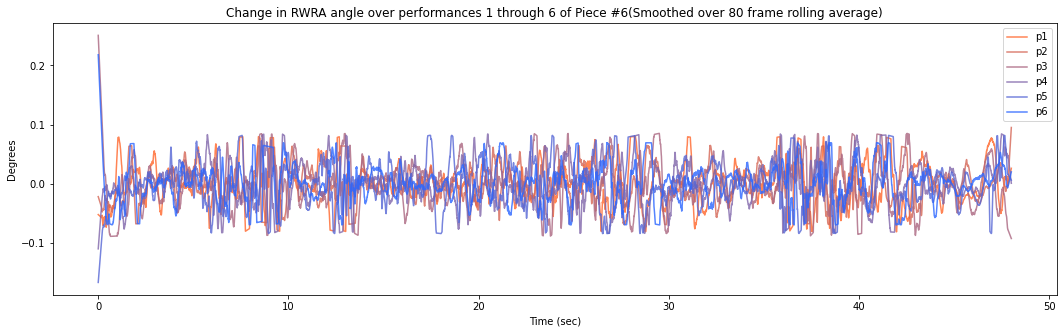

In [14]:
import sys
sys.path.append("..")
import csv_tangenting as t

# Smoothed-derivative plotting things?
for piece in [1,2,3,5,6]:
    angLST = [angLSHO,angLELB,angLWRA,angRSHO,angRELB,angRWRA] # list of angles to loop through
    # the 6 performances of a piece; repo(df) and vals(np array)
    p1,p2,p3,p4,p5,p6 = np_piece_data_from_csv(1,piece),np_piece_data_from_csv(2,piece),np_piece_data_from_csv(3,piece),np_piece_data_from_csv(4,piece),np_piece_data_from_csv(5,piece),np_piece_data_from_csv(6,piece) # the 6 performances of a piece; repo(df) and vals(np array)

    for ang in angLST:
        angpick = ang
        limbName = angpick[1]
        a1,a2,a3,a4,a5,a6 = getDegrees2D(p1[0], p1[1], angpick),getDegrees2D(p2[0], p2[1], angpick),getDegrees2D(p3[0], p3[1], angpick),getDegrees2D(p4[0], p4[1], angpick),getDegrees2D(p5[0], p5[1], angpick),getDegrees2D(p6[0], p6[1], angpick)
        arrayLST = [a1,a2,a3,a4,a5,a6]
        [a1,a2,a3,a4,a5,a6] = t.callDeriv(arrayLST,smoothed=True)
        title = "Change in "+limbName+" angle over performances 1 through 6 of Piece #"+str(piece)+ "(Smoothed over 80 frame rolling average)"
        pl = plot_degVStime2Dm([a1,a2,a3,a4,a5,a6], ['p1','p2','p3','p4','p5','p6'], title=title)
 
        plt.show()
        #plt.savefig('/Users/HAQbook/Desktop/graaaaphs/d20_'+limbName+'ang_piece'+str(piece)+'_2D.png')
